# Use case: Estimation of Caspian sea retreat using surface albedo
### User question: Can the satellite albedo datasets be used for studying the retreat of the Caspian Sea Basin?

The Caspian Sea is the world's largest inland water body. However, the water body is found to be shrinking over past many years. It is being warned that Caspian Sea could decline by 9-18 meters by the end of the century. The shrinking size of the sea would adversely affect the ecosystem, food security and livelihoods of many people with various socio-economic consequences, local and regional conflicts. In this application, we will quantify the Caspian sea retreat using surface albedo from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The Lake water levels from 2006 to 2020 derived from satellite observations shall also be collected for the same time-period. The surface albedo data of the Caspian Sea region during 2006-2020 shall be collected from CDS. The time series of albedo and water level shall be analyzed to estimate trends in the retreat of the Caspian sea. This notebook assesses the capability of the  albedo dataset in capturing retreat of Caspian sea. It  concluded that the CDS surface albedo 10-daily gridded dataset is capable of capturing the retreat of the Caspian Sea.

### Quality assessment statement

* The CDS surface albedo 10-daily gridded dataset is capable to capture the retreat of Caspian sea.
* In the selected area of the northern Caspian sea, trend of surface albedo exhibits minor fluctuations with a general decreasing trend. The declining trend of surface albedo is in agreement with that of water surface height.
* The obtained albedo trend align with other studies (Akbari et al., 2022 and Lahijani et. al., 2023) which indicate minor changes in Caspian water level with an overall falling trend.
* Previous studies (Chen et al., 2017; Samant and Prange, 2023) reveal a Caspian sea level decline of ~1.5 m in 26 years (i.e., 7cm/year) during time-period 1996–2021 and the decline has intensified (i.e., 10cm/year) in the recent years during 2006-2021.
* This study shows that CDS surface albedo can be used for capturing the retreat of Caspian sea.

### Methodology
1. Download surface albedo data  SPOT VGT v2 (time-period 2006-2014)
(horizontal_resolution: ~ 1km) and PROBA VGT v2 (time-period 2014-2021)
(horizontal_resolution: ~ 1km).
2. Download satellite lake water level data version 4.0 for Caspian sea (southwestern asia).
3. Create timeseries of albedo and lake water level over the selected area of the northern Caspian sea.

### Analysis and Results

* Import packages: We use standard libraries (numpy, pandas, xarray, cartopy.crs, matplotlib.colors, matplotlib.pyplot) for this notebook. 
* Define parameters and transform data: After defining the parameters, we use a very basic processing (time-weighted and spatial-weighted mean) over the selected region and transform the data.
* Plot timeseries: Then, we plot the time series of albedo and water surface height data.

### Import packages

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
plt.style.use("seaborn-v0_8-notebook")


### Define parameters

In [2]:
collection_id = "satellite-albedo"
chunks = {"year": 1}

common_request = {"format": "zip",
    "variable": "albb_bh",
    "product_version": "v2",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "nominal_day": "10",
    "area": [46.91, 50.75, 46.81, 50.85],
    
}
requests = {
    "spot": {
       "year": [str(year) for year in range(2006, 2014)],
        "horizontal_resolution": "1km",
        "sensor": "vgt",
    },
    "proba": {
        "year": [str(year) for year in range(2014, 2021)],
        "horizontal_resolution": "1km",
        "sensor": "vgt",
    },
}


collection_id_lake = "satellite-lake-water-level"
request_lake = {
    "variable": "water_surface_height_above_reference_datum",
    "version": "version_4_0",
    "format": "zip",
    "lake": "caspian",
    "region": "southwestern_asia",
}


### Transform data

In [3]:
maps = {}
timeseries = []
for satellite, request in requests.items():
    print(f"{satellite=}")

    maps[satellite] = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_chunks=False,
        transform_func=diagnostics.time_weighted_mean,
        drop_variables=["crs"],
    )

    ds = download.download_and_transform(
        collection_id,
        common_request | request | {"satellite": satellite},
        chunks=chunks,
        transform_func=diagnostics.spatial_weighted_mean,
        drop_variables=["crs"],
    )
    timeseries.append(ds)

ds_timeseries = xr.concat(timeseries, "time")
ds_lake = download.download_and_transform(collection_id_lake, request_lake)
ds_lake_subset = ds_lake.sel(time=slice("2006-01-01", "2020-06-30"))



satellite='spot'


100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


satellite='proba'


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


### Plot timeseries

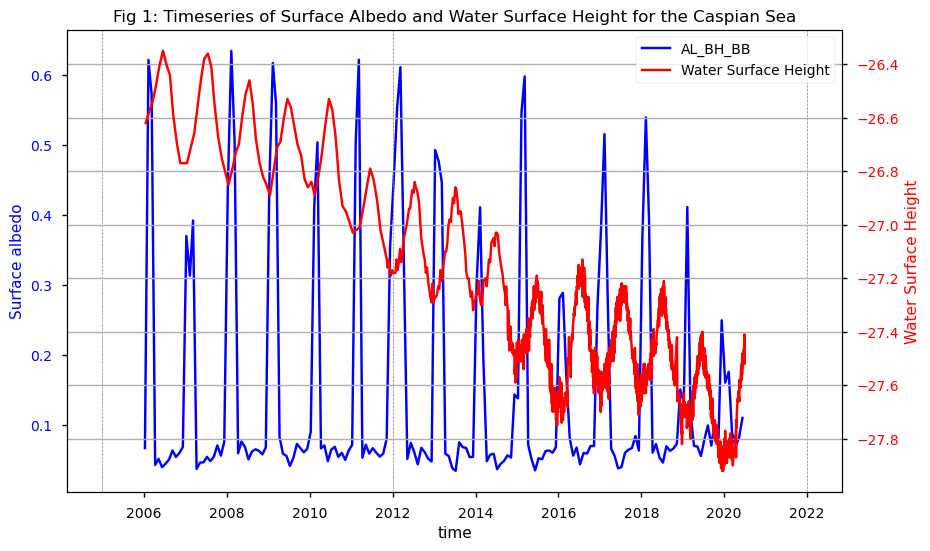

In [4]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first variable from ds_timeseries
ds_timeseries["AL_BH_BB"].plot(ax=ax1, color='blue', label='AL_BH_BB')
ax1.set_ylabel('Surface albedo', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Check if the variable exists in ds and plot it
if "water_surface_height_above_reference_datum" in ds_lake_subset:
    # Create a twin axis sharing the x-axis
    ax2 = ax1.twinx() # Plot the variable from ds if it exists
    ds_lake_subset["water_surface_height_above_reference_datum"].plot(ax=ax2, color='red', label='Water Surface Height')
    ax2.set_ylabel('Water Surface Height', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Add vertical lines
vertical_lines = ['2005-01-01', '2012-01-01', '2021-12-31']
for line in vertical_lines:
    ax1.axvline(x=datetime.strptime(line, '%Y-%m-%d'), color='gray', linestyle='--', linewidth=0.5)
    if "water_surface_height_above_reference_datum" in ds:
        ax2.axvline(x=datetime.strptime(line, '%Y-%m-%d'), color='gray', linestyle='--', linewidth=0.5)

# Set title
plt.title("Fig 1: Timeseries of Surface Albedo and Water Surface Height for the Caspian Sea")

# Show grid
plt.grid()
plt.show()

### Results

* The albedo plot indicates that significant snowfall occurs in the selected region of the northern Caspian Sea during the winter months, as evidenced by the mean albedo reaching approximately 0.6. Albedo has not reached 0.6 since 2012, which suggests less snowfall. This happens as the water's surface height begins to decline.
* The minimum albedo has increased since 2016, suggesting that the selected region of the northern Caspian Sea has retreated and become less submerged in water.
* In the selected area of the northern Caspian Sea, the obtained albedo trend aligns with other studies (Akbari et al., 2022; Lahijani et. al., 2023), which indicate minor changes in Caspian water level with an overall falling trend.
* Previous studies (Chen et al., 2017; Samant and Prange, 2023) reveal a Caspian sea level decline of ~1.5 m in 26 years (i.e., 7 cm/year) during the time period 1996–2021, and the decline has intensified (i.e., 10 cm/year) in recent years during 2006–2021.
* This study shows that the CDS surface albedo 10-daily gridded dataset is capable of capturing the retreat of the Caspian Sea.
 

### References

Akbari, E., Hamzeh, S., Kakroodi, A. A., & Maanan, M. (2022). Time series analysis of the Caspian Sea shoreline in response to sea level fluctuation using remotely sensed data. Regional Studies in Marine Science, 56, 102672.
Chen, J. L., Pekker, T., Wilson, C. R., Tapley, B. D., Kostianoy, A. G., Cretaux, J. F., & Safarov, E. S. (2017). Long‐term Caspian Sea level change. Geophysical Research Letters, 44(13), 6993-7001.
Lahijani, H., Leroy, S. A. G., Arpe, K., & Cretaux, J. F. (2023). Caspian Sea level changes during instrumental period, its impact and forecast: A review. Earth-Science Reviews, 241, 104428.
Samant, R., & Prange, M. (2023). Climate-driven 21st century Caspian Sea level decline estimated from CMIP6 projections. Communications Earth & Environment, 4(1), 357.